## Competition aim and project summary

The dataset consists of 30,000 food images classified into 80 different classes. The goal of the competition was to create a model with the highest accuracy on the competition's test set. In my other notebooks, I have always showcased my individual work. However, for this notebook, I collaborated with my classmate, Loriana Porumb.

During the competition, we achieved a 65% accuracy by ensembling five different Googlenets. In this notebook, we ensembled a Googlenet, a ResNet, and VGG to achieve an accuracy of only 49%. Nevertheless, this notebook is the cleanest and best-suited for demonstrating our work and code.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os 
import torch  
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from torch import nn
import time

import torchvision
import os
from PIL import Image
from skimage import io
from skimage.transform import resize

import pandas as pd
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

## Get file paths

In [3]:
labels_path = '/kaggle/input/food-recognition-challenge-2022/train_labels.csv'
train_path = '/kaggle/input/food-recognition-challenge-2022/train_set/train_set/train_set'

## Explore classes

Exploring the classes, we'll see that we are dealing with 80 classes and some class imbalance. While most classes have around 300-500 images, class 20 has less than 50 images.

In [6]:
labels_df = pd.read_csv(labels_path)

In [7]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30612 entries, 0 to 30611
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   img_name  30612 non-null  object
 1   label     30612 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 478.4+ KB


In [8]:
print(f'We have {labels_df.nunique()[1]} classes')

We have 80 classes


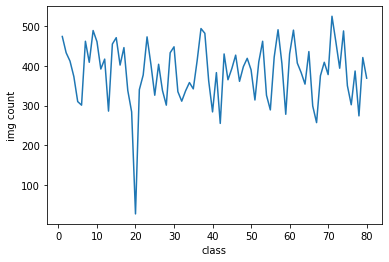

In [9]:
import matplotlib.pyplot as plt
labels_count = labels_df.groupby('label').count()
fig,ax = plt.subplots()
plt.ylabel('img count')
plt.xlabel('class')
ax.plot(labels_count)
plt.show()

## Custom Dataset

Our data is organized like:
* one train folder
* one test folder
* a csv of the form: image | image class number (1-80 since we have 80 classes)
* a csv linking each class number to the class' text description

We want a custom Dataset object that returns each image together with its numeric class label.

We want the Dataset object to return for each index the corresponding image, and its label. For that, we write our custom Dataset class.

In [4]:
import os
from PIL import Image
from skimage import io
from skimage.transform import resize

import pandas as pd
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [5]:
torch.manual_seed(0)

In [6]:
class Dataset(Dataset):
    def __init__(self, labels, image_dir, transform=None):
        self.labels = pd.read_csv(labels)
        self.image_dir = image_dir
        self.transform = transform
    
    def __len__(self):
        'Gets total num of samples'
        return len(self.labels)
    
    def __getitem__(self, index):
        'Gets image and corresponding label as tensors'
        ipath = os.path.join(self.image_dir, self.labels.iloc[index, 0])
        image = Image.open(ipath)
        label_tensor = torch.tensor(int(self.labels.iloc[index, 1]-1))
        
        if self.transform:
            tensor_transform = transforms.Compose([transforms.ToTensor()])
            image = tensor_transform(image)
            image = self.transform(image) #custom transforms if any
            
        return (image, label_tensor)

## Image Transformations

Other than just converting to a tensor, we'll want to apply further transformations like normalization and cropping (which will work best if out theory that the relevant image part is in the center holds).

To normalize, we need to first get the mean and standard deviation across all images.

But before we start, a note about the cropping. Since we want to do transfer learning on an ensemble of models, we need to check the image dimensions that these models require.

Models:
- GoogLeNet: 224 X 224
- VGG16: 224 X 224
- ResNet18: 224 X 224

Since they're all requiring the same input image size, we're good. Otherwise, we'd have to crop them to the desired dimensions for each model separately.

In [7]:
def get_mean_and_std(dataloader):
    """Gets mean and std for the dataset by chanel so we can normalize the images"""
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5

    return mean, std

We can get the mean and std by passing in a Dataloader object.

But to get a dataloader object, we already need to tensorize the custom Dataset.

Which is why we add a `toTensor()` transform inside the custom dataset, and then we can pass all other custom transforms extra through the transform parameter.

In [8]:
base_transform = transforms.Compose([transforms.Resize((256,256))])

In [9]:
# create a dataset and a dataloader for it so that we can get the mean and std
# but don't apply other transformations than the base transform
ds = Dataset(labels = labels_path, 
            image_dir = train_path,
            transform = base_transform)
ds_loader = DataLoader(ds)
mean, std = get_mean_and_std(ds_loader)
print(mean, std)

tensor([0.6365, 0.5436, 0.4452]) tensor([0.2733, 0.2891, 0.3160])


In [10]:
# custom transforms
transform = transforms.Compose([transforms.Resize((256,256)),
                                transforms.Normalize(mean, std) #normalize only works on tensors, so tensorize before
                                ])

In [11]:
# now we create the dataset again, but with the extra transforms (including normalization)
train_folder = Dataset(labels = labels_path, 
                  image_dir = train_path,
                  transform = transform)

In [13]:
# splitting the loader into train and validation 
train_set_size = int(len(train_folder) * 0.8)
valid_set_size = len(train_folder) - train_set_size
train_dataset, validation_dataset = torch.utils.data.random_split(train_folder, [train_set_size, valid_set_size])

test_set = DataLoader(train_dataset)
validation_set = DataLoader(validation_dataset)

In [14]:
# displaying one image from each (train, validation) to make sure nothing exploded
def show_one_img(dloader):
    data_iter = iter(dloader)
    images, labels = next(data_iter)
    plt.imshow(images[0].permute(1, 2, 0))

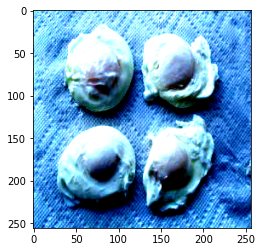

In [15]:
show_one_img(test_set)

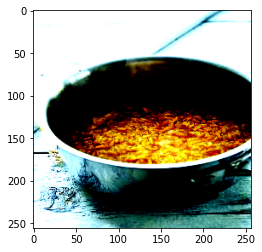

In [16]:
show_one_img(validation_set)

## Dealing with imbalanced datasets

Since we have way fewer training examples for some of the classes, we wanted to give weights like 1/num_examples to each class, so that classes with fewer examples have higher weight numbers, and those with more examples less.

However, over the epochs of training (max 15 so far) this failed to deliver better accuracy, or even lead to a way lower one (weirdly).

***Uncomment to add class weights***

In [ ]:
#Uncomment this for weights

# class_weights = (1/labels_count.values).reshape(-1) 
# class_weights = class_weights.tolist()
# sample_weights = [0] * len(test_set)

# for idx, (data, label) in enumerate(test_set): #this will take some minutes
#     class_weight = class_weights[label]
#     sample_weights[idx] = class_weight
#     if idx % 1000 == 0:
#         print(idx)

# from torch.utils.data import WeightedRandomSampler

# # we pass this custom sampler to the dataloader when we load the datasets
# sample = WeightedRandomSampler(sample_weights, 
#                                num_samples = len(sample_weights), 
#                                replacement=True)

In [17]:
#hyperparameters
batch_size = 64

***In the code block below, add `, sampler=sample` to the train data loader if you want to use the weights***

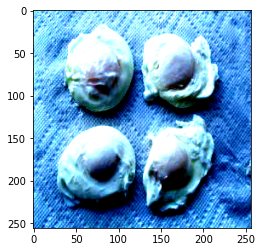

In [18]:
# re-loading the train and test, this time with class weights via sampler
torch.manual_seed(0)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size) #, sampler=sample
validation_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=True)

show_one_img(train_loader)

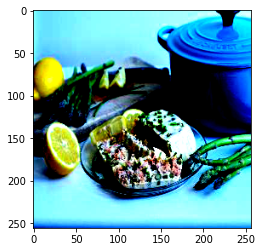

In [19]:
show_one_img(validation_loader)

## Setting up the device

In [20]:
#device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## Trying out transfer learning with GoogLeNet

The approach will be to train three models separately using transfer learning. We'll let them run for as many epochs as they can before they start overfitting, by implementing an early stop.

Finally, we'll aggregate the predictions, and for that we'll try two approaches:
- freezing the weights of the pretrained models and incorporating these models in anoter model, whose only trainable layer is the last one, a classifier
- averaging over the three model's predictions and using softmax so that the sums of probabilities for each of our 80 classes amounts to 1

But more to that later.

***Important:***

When training the pretrained model, we're not freezing the model's params. This means that the weights of the pretrained model are being updated with every backprop. This takes longer, but it should also make the model better tailored to our case.



In [21]:
import torchvision
from torch import nn

from torch import optim
import torch.optim.lr_scheduler as lr_scheduler
import time

In [22]:
googlenet = torchvision.models.googlenet(pretrained = True)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [23]:
vgg16 = torchvision.models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [24]:
resnet = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

The pretrained models have 1000 outputs each, which means they predict probabilities for 1000 classes by default. 

But since we have only 80 classes, we want to replace the output layer of each model with one that takes just as many inputs, but has only 80 outputs. 

The number of inputs should stay the same since we want the last layer to stull hold all connections to the nodes in the prev layer that the original output layer was connected to.

In [28]:
# finetunning the pretrained models

num_classes = 80 # we have 80 classes in our dataset

# replace last googlenet layer
num_features = googlenet.fc.in_features
googlenet.fc = nn.Linear(num_features,num_classes)

#replace last vgg16 layer
#in this case, the model output comes from the 6th layer of the classifier, hence [6]
num_features = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_features, num_classes)

#replace last resnet18 layer
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, num_classes)

In [29]:
googlenet.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [30]:
vgg16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [31]:
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [32]:
learning_rate = 0.001
num_epochs = 32 # we set it to 32 since we want the models to train for as long as possible before stopping due to overfitting

## Training and Validating

The function below trains a model for an epoch. To train for several epochs, it needs to be called in a loop.

In [33]:
def train_an_epoch(model, data_loader, train_dataset): #, criterion, optimizer, scheduler
    
    since = time.time()
    
    #loss function, optimizer, and lr scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, verbose=True)
    
    model.train()
    
    running_loss = 0
    running_corrects = 0
        
    for batch_idx, (data, targets) in enumerate(data_loader):
        if batch_idx % 100 == 0:
            print(f'batch_idx: {batch_idx}')
        data = data.to(device)
        targets = targets.to(device)
            
        # ---- forward pass ----
        scores = model(data) # the outputs are log-probabilities (so likelihood scores)
        loss = criterion(scores, targets) #calc loss
            
        running_loss += loss.item() * data.size(0) #adding current batch's loss to the epoch's loss
        _, predictions = torch.max(scores, 1) 
        running_corrects += torch.sum(predictions == targets.data )
            
        # ---- backprop ----
        optimizer.zero_grad() #resetting grads before we start
        loss.backward() # backward prop where model learns new weights
        optimizer.step() # here we update the weights
        
    epoch_loss = running_loss / len(train_dataset)
    epoch_accuracy = running_corrects.double() / len(train_dataset)
        
    scheduler.step(epoch_loss)
            
    print(f'Avg loss: {epoch_loss}')
    print(f'Avg accuracy: {epoch_accuracy}')
        
    time_elapsed = time.time() - since
    print('Epoch Training done in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    
    return epoch_accuracy, epoch_loss

In [34]:
def validate(loader, model, validation_dataset):  
    
    num_correct = 0
    num_samples = 0
    running_loss = 0
    criterion = nn.CrossEntropyLoss()
    model.eval()
    
    with torch.no_grad(): #no need to compute the gradients in the calculation
        for batch_idx, (x, y) in enumerate(loader):
            x = x.to(device=device)
            y = y.to(device=device)
            
            scores = model(x)
            batch_loss = criterion(scores, y)
            
            running_loss += batch_loss.item() * x.size(0)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        ep_acc = float(num_correct)/float(num_samples)*100
        ep_loss = running_loss/len(validation_dataset)
        print(f'VALIDATION: Got {num_correct} / {num_samples} with accuracy {ep_acc:.2f} and loss {ep_loss: .2f}')
        
    return ep_acc, ep_loss

#### Run the cell below to train and validate after each epoch

In [36]:
def train_validate_plot(model, model_name, train_loader, validation_loader, train_dataset, validation_dataset): #, criterion, optimizer, scheduler
    '''
    This trains for num_epochs, stops if the validation accuracy stagnates or gets worse for 3 epochs, 
    and finally plots the train loss, train accuracy, and validtion accuracy across the epochs.
    '''

    losses_train = []
    accuracies_train = []
    accuracies_val = []
    losses_val = []
    
    trigger = 0
    patience = 3 #we wait for 3 unsuccesful eps before we call it quits with bitter tears in our eyes
    
    last_ep = 0
    
    for epoch in range(num_epochs):
        print(f'********** Epoch {epoch}/{num_epochs} **********')
        #training
        train_accuracy, train_loss = train_an_epoch(model, train_loader, train_dataset)
        losses_train.append(train_loss)
        accuracies_train.append(train_accuracy)
        #validating
        val_accuracy, val_loss = validate(validation_loader, model, validation_dataset)
        accuracies_val.append(val_accuracy)
        losses_val.append(val_loss)
        
        last_ep = epoch #this is for the x axis in the plot at the end
        
        
        # early stopping (check after each epoch)
        current_val_loss_index = losses_val.index(val_loss)
        #if the current ep loss is roughly equal or higher than prev eps', increase the trigger
        if current_val_loss_index > 0 and (round(losses_val[current_val_loss_index],1) >=  round(losses_val[current_val_loss_index-1], 1)) or current_val_loss_index >= 3 and (round(losses_val[current_val_loss_index],1) >=  round(losses_val[current_val_loss_index-3], 1)):
            trigger += 1
            print(f'!early stop triggered! trigger = {trigger}')
            if trigger >= patience:
                print('Stopped early cause things were going BAAAD')
                break
        else:
            trigger = 0 #if current eps' accuracy is not <=, then reset the trigger to 0
        
        
    # plot train losses vs validate accuracies
    epochs = np.arange(last_ep+1)+1
    accuracies_train = [a.cpu() for a in accuracies_train]
    accuracies_val = [a/100 for a in accuracies_val]

    plt.plot(epochs, losses_train, label = "train_loss")
    plt.plot(epochs, losses_val, label = "eval_loss")
    plt.plot(epochs, accuracies_train, label = "accuracy_train")
    plt.plot(epochs, accuracies_val, label = "accuracy_val")
    plt.legend()
    plt.title(model_name)
    plt.show()

********** Epoch 0/32 **********
batch_idx: 0


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


batch_idx: 100
batch_idx: 200
batch_idx: 300
Avg loss: 2.688345978417662
Avg accuracy: 0.36085589448323735
Epoch Training done in 2m 55s
VALIDATION: Got 2846 / 6123 with accuracy 46.48 and loss  2.09
********** Epoch 1/32 **********
batch_idx: 0
batch_idx: 100
batch_idx: 200
batch_idx: 300
Avg loss: 1.581823523546269
Avg accuracy: 0.5901016783045449
Epoch Training done in 2m 42s
VALIDATION: Got 3050 / 6123 with accuracy 49.81 and loss  1.95
********** Epoch 2/32 **********
batch_idx: 0
batch_idx: 100
batch_idx: 200
batch_idx: 300
Avg loss: 1.0813226752791536
Avg accuracy: 0.7169341336926783
Epoch Training done in 2m 40s
VALIDATION: Got 3112 / 6123 with accuracy 50.82 and loss  2.00
!early stop triggered! trigger = 1
********** Epoch 3/32 **********
batch_idx: 0
batch_idx: 100
batch_idx: 200
batch_idx: 300
Avg loss: 0.7262619760194284
Avg accuracy: 0.8108538527502144
Epoch Training done in 2m 38s
VALIDATION: Got 2885 / 6123 with accuracy 47.12 and loss  2.36
!early stop triggered! trigg

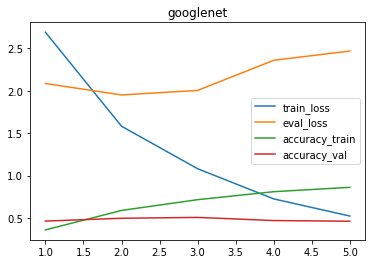

In [37]:
#googlenet
train_validate_plot(googlenet, 'googlenet', train_loader, validation_loader, train_dataset, validation_dataset) 

********** Epoch 0/32 **********
batch_idx: 0
batch_idx: 100
batch_idx: 200
batch_idx: 300
Avg loss: 2.965834382676695
Avg accuracy: 0.2768181632569725
Epoch Training done in 5m 7s
VALIDATION: Got 2414 / 6123 with accuracy 39.43 and loss  2.39
********** Epoch 1/32 **********
batch_idx: 0
batch_idx: 100
batch_idx: 200
batch_idx: 300
Avg loss: 2.1687225118127946
Avg accuracy: 0.44219853811915555
Epoch Training done in 4m 36s
VALIDATION: Got 2773 / 6123 with accuracy 45.29 and loss  2.17
********** Epoch 2/32 **********
batch_idx: 0
batch_idx: 100
batch_idx: 200
batch_idx: 300
Avg loss: 1.812419335159365
Avg accuracy: 0.5260729307035812
Epoch Training done in 4m 36s
VALIDATION: Got 2869 / 6123 with accuracy 46.86 and loss  2.08
********** Epoch 3/32 **********
batch_idx: 0
batch_idx: 100
batch_idx: 200
batch_idx: 300
Avg loss: 1.5602969488812728
Avg accuracy: 0.5832822900077586
Epoch Training done in 4m 36s
VALIDATION: Got 2981 / 6123 with accuracy 48.69 and loss  2.03
********** Epoch 4

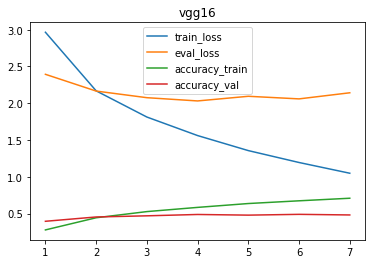

In [38]:
#vgg16
train_validate_plot(vgg16, 'vgg16', train_loader, validation_loader, train_dataset, validation_dataset) 

********** Epoch 0/32 **********
batch_idx: 0
batch_idx: 100
batch_idx: 200
batch_idx: 300
Avg loss: 2.394505864399071
Avg accuracy: 0.40936747110947774
Epoch Training done in 2m 20s
VALIDATION: Got 2489 / 6123 with accuracy 40.65 and loss  2.41
********** Epoch 1/32 **********
batch_idx: 0
batch_idx: 100
batch_idx: 200
batch_idx: 300
Avg loss: 1.402576823564405
Avg accuracy: 0.628935440401813
Epoch Training done in 2m 21s
VALIDATION: Got 2587 / 6123 with accuracy 42.25 and loss  2.40
!early stop triggered! trigger = 1
********** Epoch 2/32 **********
batch_idx: 0
batch_idx: 100
batch_idx: 200
batch_idx: 300
Avg loss: 0.8223384693627009
Avg accuracy: 0.7819429131446772
Epoch Training done in 2m 20s
VALIDATION: Got 2426 / 6123 with accuracy 39.62 and loss  2.71
!early stop triggered! trigger = 2
********** Epoch 3/32 **********
batch_idx: 0
batch_idx: 100
batch_idx: 200
batch_idx: 300
Avg loss: 0.45135841159726314
Avg accuracy: 0.8830903671035976
Epoch Training done in 2m 20s
VALIDATION

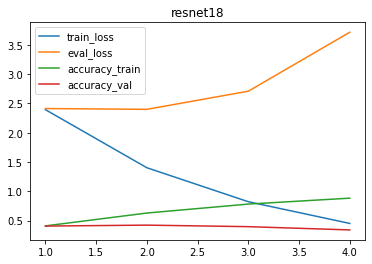

In [39]:
#resnet18
train_validate_plot(resnet, 'resnet18', train_loader, validation_loader, train_dataset, validation_dataset)

In [41]:
# save model 
def save_model(model, path):
    model_name = path
    torch.save(model.state_dict(), model_name)
    
save_model(googlenet, 'googlenet')
save_model(vgg16, 'vgg16')
save_model(resnet, 'resnet18')

To then use the saved models, we need to load the pretrained model as before, finetune it, then update the weights by loading the saved model:

`
googlenet = torchvision.models.googlenet(pretrained = True)
googlenet.fc = nn.Linear(1024, 80)
googlenet.load_state_dict(torch.load("/kaggle/working/googlenet", map_location=torch.device(device)))
googlenet.to(device)
`

## Ensemble learning

In [52]:

# taking predictions of model A, predictions of model B, then averaging them for each class
# then taking index of the max value in the array of max predictions

def ensemble_pred_labels(loader, modelA, modelB, modelC):  
    labels = []
    num_correct = 0
    num_samples = 0
    modelA.eval()
    modelB.eval()
    
    with torch.no_grad(): #no need to compute the gradients in the calculation
        for batch_idx, (x, y) in enumerate(loader):
#             print("batch_idx:", batch_idx)
            x = x.to(device=device)
            y = y.to(device=device)
            
            scoresA = torch.nn.functional.softmax(modelA(x), dim=1)
            scoresB = torch.nn.functional.softmax(modelB(x), dim=1)
            avg_scores = torch.div(torch.add(scoresA, scoresB), 2) #averaging here
            _, predictions = avg_scores.max(1)
            labels.extend([pred.item() for pred in predictions])
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        acc = float(num_correct)/float(num_samples)*100
        print(f'VALIDATION: Got {num_correct} / {num_samples} with accuracy {acc:.2f}')
        
    return acc, labels


In [53]:
acc, labels = ensemble_pred_labels(validation_loader, googlenet, resnet, vgg16)

VALIDATION: Got 3043 / 6123 with accuracy 49.70


## Conclusion

The 49.7 accuracy got out of ensembling is an around 1% improvement from the accuracy of the best model in the ensemble.
But this can def be improved by increasing the model complexity, adding more transformations, maybe even generating some more images based on the existing ones, and training for more epochs by making the early stop functionality less strict.
